In [78]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import pandas as pd
from statsmodels.stats.power import TTestIndPower

In [93]:
def perform_power_analysis(effect_size, alpha, nobs1, desired_power, sample_sizes=None):
    """
    Выполняет анализ мощности и визуализирует зависимость мощности от размера выборки.
    
    Параметры:
      effect_size: Размер эффекта (Cohen's d)
      alpha: Уровень значимости
      nobs1: Размер выборки для группы A (предполагается равенство групп)
      desired_power: Желаемая мощность теста (например, 0.8 для 80%)
      sample_sizes: (Опционально) массив значений размера выборки для построения графика.
                    Если не задан, используется диапазон от 100 до 2000 с шагом 50.
    """
    analysis = TTestIndPower()
    
    current_power = analysis.power(effect_size=effect_size, nobs1=nobs1, alpha=alpha, ratio=1.0)
    print(f"Мощность теста при n = {nobs1}: {current_power:.4f}")
    
    required_n = analysis.solve_power(effect_size=effect_size, power=desired_power, alpha=alpha, ratio=1.0)
    print(f"Требуемый размер выборки на группу для мощности {desired_power*100:.0f}%: {required_n:.0f}")
    
    if sample_sizes is None:
        sample_sizes = np.arange(100, 2000, 50)
    
    powers = analysis.power(effect_size=effect_size, nobs1=sample_sizes, alpha=alpha, ratio=1.0)
    
    plt.figure(figsize=(10, 6))
    plt.plot(sample_sizes, powers, marker='o', linestyle='-', label='Мощность теста')
    plt.axhline(desired_power, color='red', linestyle='--', label=f'Желаемая мощность: {desired_power}')
    plt.xlabel('Размер выборки на группу')
    plt.ylabel('Мощность теста')
    plt.title("Зависимость мощности теста от размера выборки")
    plt.legend()
    plt.grid(True)
    plt.show()

In [79]:
np.random.seed(42)

Количество наблюдений и успехов в группах (биномиальная метрика, например, конверсии)

In [80]:
n_A, successes_A = 1000, 200  
n_B, successes_B = 1000, 230  

In [81]:
alpha_prior, beta_prior = 1, 1

Генерация постериорных распределений для каждой группы

In [82]:
posterior_A = stats.beta(alpha_prior + successes_A, beta_prior + (n_A - successes_A))
posterior_B = stats.beta(alpha_prior + successes_B, beta_prior + (n_B - successes_B))

In [83]:
samples_A = posterior_A.rvs(10000)
samples_B = posterior_B.rvs(10000)

In [84]:
prob_B_better_A = np.mean(samples_B > samples_A)

In [85]:
delta = samples_B - samples_A

Доверительный интервал HPD (Highest Posterior Density Interval)

In [86]:
hpd_interval = az.hdi(delta, hdi_prob=0.95)

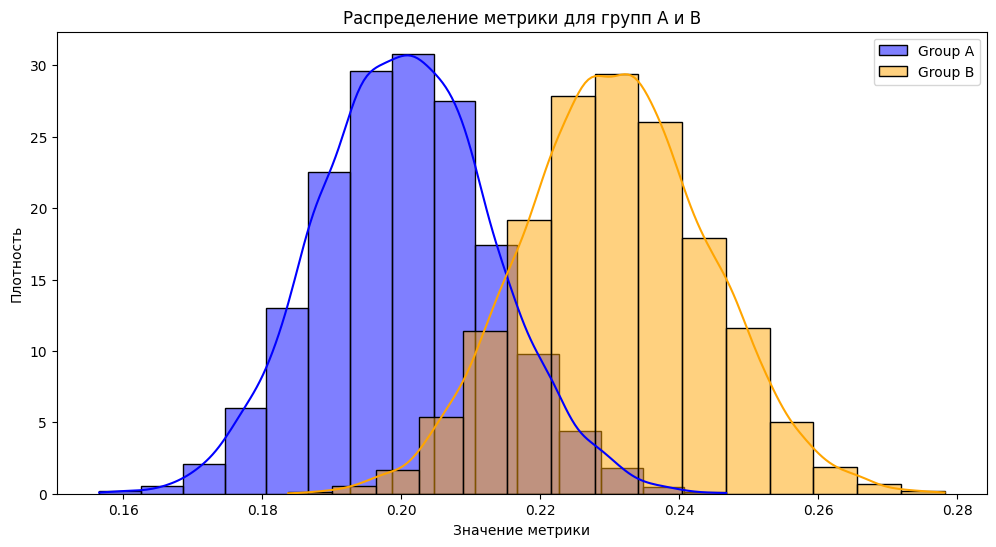

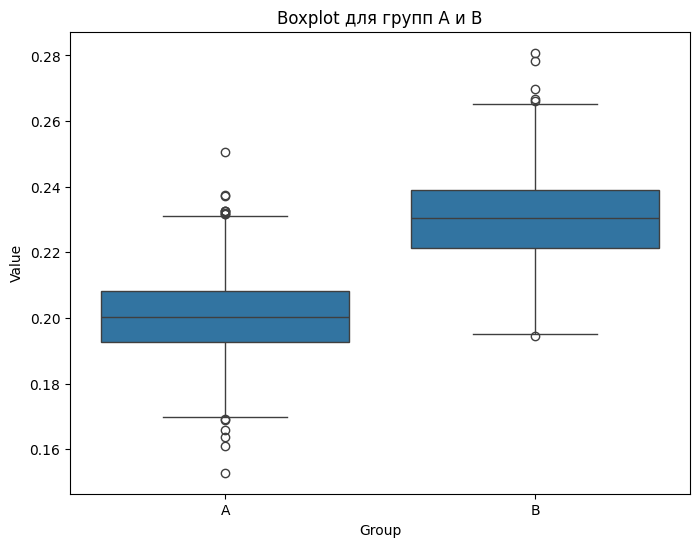

In [87]:
plt.figure(figsize=(12, 6))
sns.histplot(samples_A, color='blue', label='Group A', kde=True, stat="density", bins=15)
sns.histplot(samples_B, color='orange', label='Group B', kde=True, stat="density", bins=15)
plt.title('Распределение метрики для групп A и B')
plt.xlabel('Значение метрики')
plt.ylabel('Плотность')
plt.legend()
plt.show()

samples_A = posterior_A.rvs(n_A) 
samples_B = posterior_B.rvs(n_B) 

data = pd.DataFrame({'Group': ['A'] * n_A + ['B'] * n_B,
                     'Value': np.concatenate([samples_A, samples_B])})
plt.figure(figsize=(8, 6))
sns.boxplot(x='Group', y='Value', data=data)
plt.title('Boxplot для групп A и B')
plt.show()

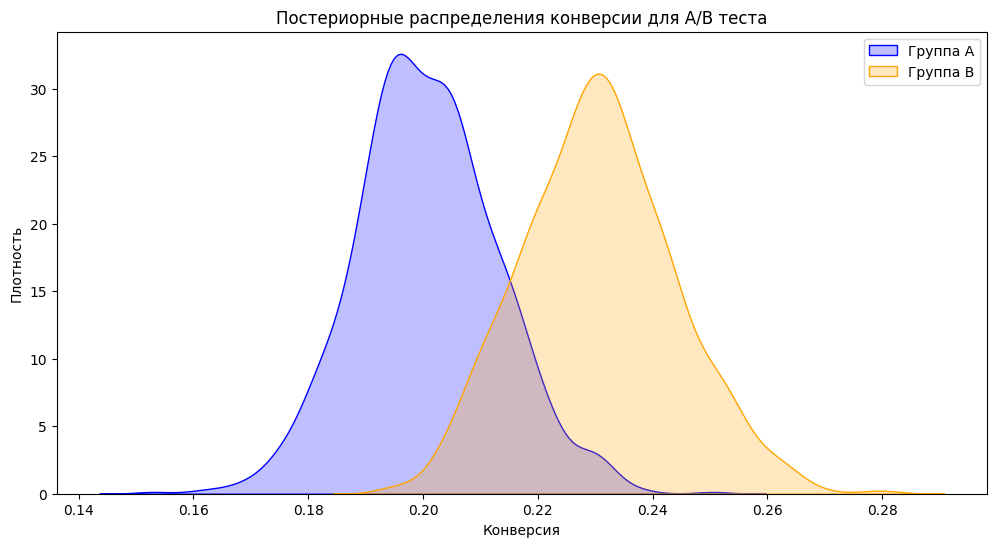

In [88]:
plt.figure(figsize=(12, 6))
sns.kdeplot(samples_A, label='Группа A', fill=True, color='blue')
sns.kdeplot(samples_B, label='Группа B', fill=True, color='orange')
plt.xlabel('Конверсия')
plt.ylabel('Плотность')
plt.title('Постериорные распределения конверсии для A/B теста')
plt.legend()
plt.show()

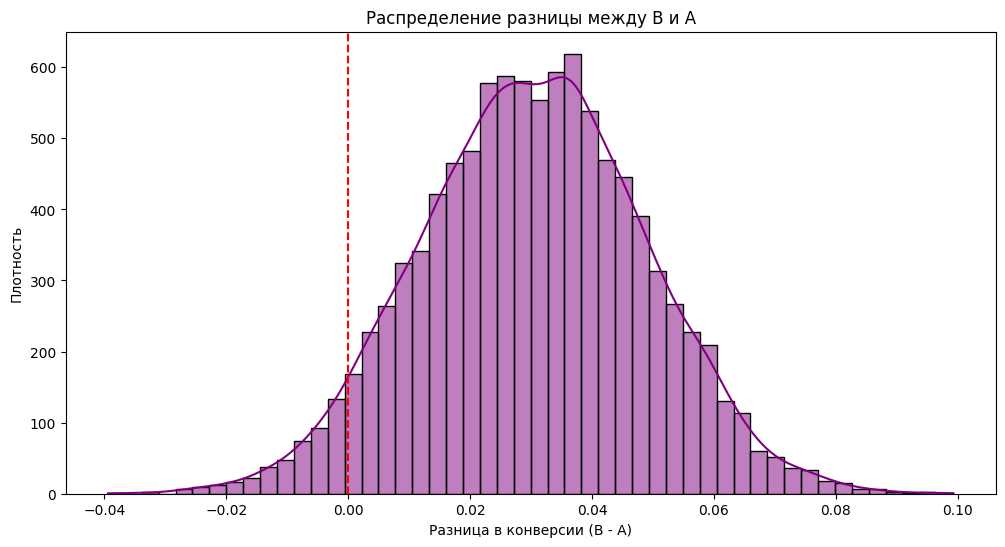

In [89]:
plt.figure(figsize=(12, 6))
sns.histplot(delta, bins=50, kde=True, color='purple')
plt.axvline(0, color='red', linestyle='dashed')
plt.xlabel('Разница в конверсии (B - A)')
plt.ylabel('Плотность')
plt.title('Распределение разницы между B и A')
plt.show()


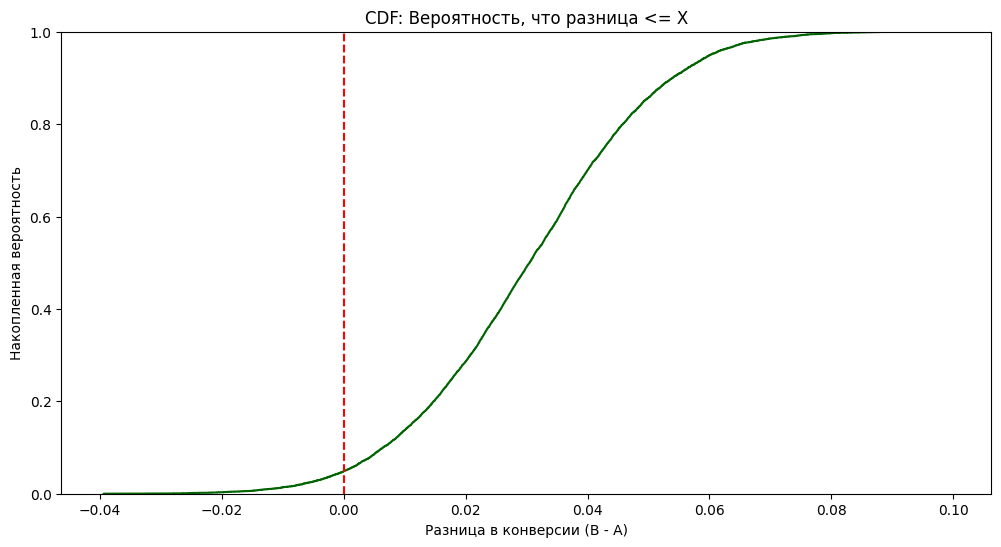

In [90]:
plt.figure(figsize=(12, 6))
sns.ecdfplot(delta, color='darkgreen')
plt.axvline(0, color='red', linestyle='dashed')
plt.xlabel('Разница в конверсии (B - A)')
plt.ylabel('Накопленная вероятность')
plt.title('CDF: Вероятность, что разница <= X')
plt.show()

Мощность теста при n = 1000: 1.0000
Требуемый размер выборки на группу для мощности 80%: 64


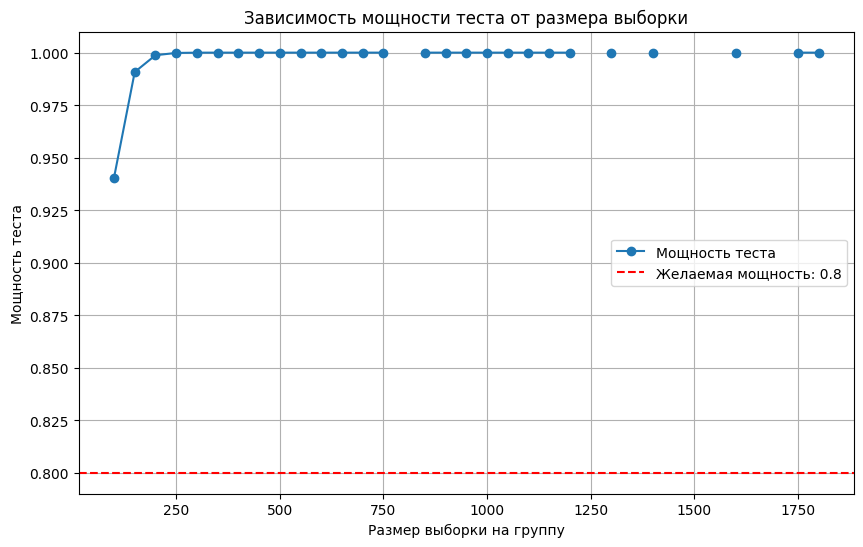

In [94]:
perform_power_analysis(effect_size=0.5, alpha=0.05, nobs1=1000, desired_power=0.8)

In [91]:
print(f"Вероятность того, что B лучше A: {prob_B_better_A:.4f}")
print(f"95% доверительный интервал для разницы: [{hpd_interval[0]:.4f}, {hpd_interval[1]:.4f}]")
if prob_B_better_A > 0.95:
    print("🎉 B значительно лучше A!")
elif prob_B_better_A < 0.05:
    print("❌ B хуже A.")
else:
    print("🤔 Различие между A и B незначительное.")

Вероятность того, что B лучше A: 0.9508
95% доверительный интервал для разницы: [-0.0052, 0.0656]
🎉 B значительно лучше A!
